In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [25]:
df = pd.read_csv("datosCabaYGBA",low_memory = False)

In [26]:
df.drop("Unnamed: 0",axis=1,inplace=True)

# Analizamos la evolucion del precio de una propiedad alrededor de la estacion de subte Las Heras, a traves del tiempo, tener en cuenta que se inauguró en diciembre de 2015

In [27]:
def propsEnZona(serie, zona):
    booleans = list()
    for item in serie:
        if item.split("|")[2] == zona:
            booleans.append(True)
        else:
            booleans.append(False)
    return booleans

In [28]:

propsCapital = df[propsEnZona(df.place_with_parent_names,"Capital Federal")]

In [29]:
propsCapital = propsCapital.dropna(subset = ["lat-lon"])

In [30]:
propsCapital = propsCapital[["property_type","created_on",\
                             "lat-lon","place_name","price_aprox_usd",\
                             "price_usd_per_m2","surface_total_in_m2"]]

In [31]:
propsRecoleta = propsCapital[propsCapital["place_name"] == "Recoleta"]

# Me quedo con propiedades con superficie total dentro de un determinado rango

In [32]:
propsRecoleta = propsRecoleta[(propsRecoleta["surface_total_in_m2"] >= 50)\
                              & (propsRecoleta["surface_total_in_m2"] <= 100)]

In [33]:
propsRecoleta = propsRecoleta.dropna(subset=["price_aprox_usd"])

In [140]:
from utils_analisis import latLonToInt,calcular_distancia
estacionLH = (-34.588203, -58.398268)


In [519]:
propsRecoleta["DistEstacionLH"] = propsRecoleta.apply(lambda row: calcular_distancia(latLonToInt(row["lat-lon"]),estacionLH),axis=1)

In [36]:
#Me quedo con las propiedades que estan e n unradio de 600 metros de la stacion LH
cercanas = propsRecoleta[propsRecoleta["DistEstacionLH"] <= 0.6 ]

In [ ]:
cercanas["YearMonthCreation"] = cercanas.apply(lambda row:\
                                "-".join(row["created_on"].split("-")[:2]),axis=1)

In [38]:
grouped = cercanas.loc[:,['YearMonthCreation','price_aprox_usd']].groupby('YearMonthCreation').\
    agg([np.mean,np.size])

In [39]:
grouped = grouped.loc[grouped[('price_aprox_usd','size')]>5,:]

In [40]:
grouped = grouped['price_aprox_usd'].drop('size',axis = 1)

In [41]:
grouped.index.rename("Año - mes",inplace= True)
grouped = grouped["mean"].rename("Promedio del precio en dolares")

In [42]:
grouped.plot(linewidth=2,figsize=(12,8),legend=True)


In [ ]:
plt.xticks( xrange(len(grouped.index)), grouped.index)

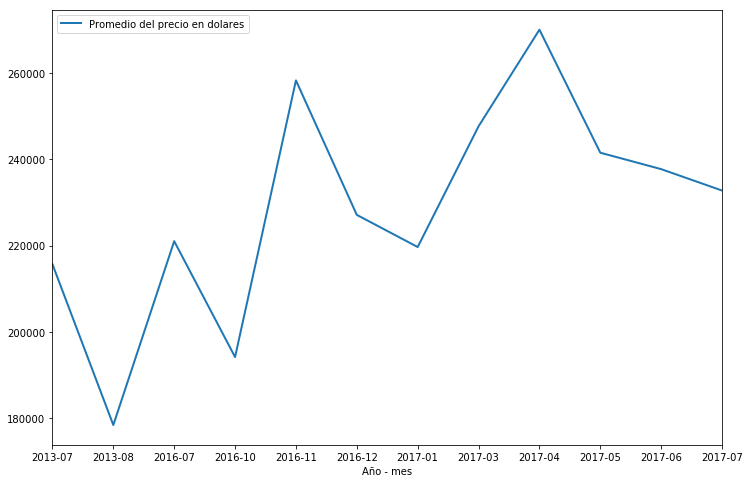

In [44]:
plt.show()

# Aunque no obtuvimos datos alredeor de la fecha deseada (2015-12) se observa como el precio promedio de una propiedad de estas caracteristicas aumentó y no decayó su precio a valores anteriores de la aparicion del subte. A partir de esto podriamos inclinarnos a estudiar como afecta la distancia al subte el precio de una propiedad

In [528]:
#Coordenadas estacion Congreso y Juramento (Linea D)
congreso = (-34.556033, -58.462183)
juramento = (-34.562541, -58.456528)

In [516]:
propsBelgrano = df[df["place_with_parent_names"].str.contains("Belgrano")]

# Estudio como varia el precio cuando me alejo de la estacion congreso (Pero siempre estar mas alejado de juramento)

In [525]:
propsBelgrano = propsBelgrano.dropna(subset=["lat-lon"])

In [526]:
propsBelgrano["distCongreso"] = propsBelgrano.apply(lambda row: calcular_distancia(latLonToInt(row["lat-lon"]),congreso),axis=1)


/home/tomas/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [529]:
propsBelgrano["distJuramento"] = propsBelgrano.apply(lambda row: calcular_distancia(latLonToInt(row["lat-lon"]),juramento),axis=1)


In [530]:
cercanasCongreso = propsBelgrano[(propsBelgrano["distCongreso"] <= 1) & 
                                propsBelgrano["distJuramento"] > propsBelgrano["distCongreso"]]

In [533]:
deptosCercanos = cercanasCongreso[cercanasCongreso["property_type"] == "apartment"]

In [535]:
deptosCercanos = deptosCercanos[deptosCercanos["price_aprox_usd"] > 0]

In [539]:
deptosCercanos = deptosCercanos[deptosCercanos["floor"] < 11]

In [542]:
deptosCercanos = deptosCercanos[deptosCercanos["rooms"] <= 4]

In [543]:
deptosCercanos.corr()

,floor,geonames_id,price_aprox_usd,price_usd_per_m2,rooms,surface_covered_in_m2,surface_total_in_m2,distCongreso,distJuramento
floor,1.000000,NaN,0.081054,0.183758,0.040258,-0.029492,0.071281,-0.038921,-0.025945
geonames_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price_aprox_usd,0.081054,NaN,1.000000,0.113296,0.704837,0.061688,0.833484,0.023945,-0.110594
price_usd_per_m2,0.183758,NaN,0.113296,1.000000,-0.149607,-0.311978,-0.357091,0.101738,0.206876
rooms,0.040258,NaN,0.704837,-0.149607,1.000000,0.021330,0.641860,0.000856,-0.206179
surface_covered_in_m2,-0.029492,NaN,0.061688,-0.311978,0.021330,1.000000,0.973810,0.070237,-0.060264
surface_total_in_m2,0.071281,NaN,0.833484,-0.357091,0.641860,0.973810,1.000000,-0.009267,-0.187086
distCongreso,-0.038921,NaN,0.023945,0.101738,0.000856,0.070237,-0.009267,1.000000,-0.153868
distJuramento,-0.025945,NaN,-0.110594,0.206876,-0.206179,-0.060264,-0.187086,-0.153868,1.000000


# Segun los resultados, si me alejo de congreso, mas valdra la propiedad, y si me acerco a juramento, mas valdra. Tiene sentido al ser juramento una zona mas centrica